In [1]:
# 2022-02-04 Homework 2 | yying2@
import sys
import math

In [2]:
class Node:
    def __init__(self):
        self.left = None
        self.right = None
        self.LV = None
        self.RV = None
        self.attr = None
        self.vote = None
        self.level = None

In [3]:
def most_frequent(List):
    label_unique = list(set(List))
    label_unique = sorted(label_unique)
    count = 0
    vote = None
    for label in label_unique:
        if List.count(label) >= count:
            count = List.count(label)
            vote = label
    return vote

In [4]:
def cal_entropy(train_label):
    distinct_label = list(set(train_label))
    size = len(train_label)
    entropy = 0
    for label in distinct_label:
        entropy = entropy + (train_label.count(label)/size * math.log(train_label.count(label)/size,2))
    return -entropy

In [5]:
def cal_MI(entropy,train_data,train_label,attribute_dict):
    MI_dict= {}
    size = len(train_label)
    for item in attribute_dict.items():
        attribute = item[0]
        data = [x[item[1]] for x in train_data]
        distinct_data = list(set(data))
        distinct_label = list(set(train_label))
        MI = entropy
        for value in distinct_data:
            count = data.count(value)
            for label in distinct_label:
                hit = 0
                for i in range(size):
                    if data[i] == value and train_label[i] == label:
                        hit+=1
                if hit != 0:
                    MI = MI +(hit/count*math.log(hit/count,2))*count/size
        if MI > 0:
            MI_dict[attribute] = MI
    if len(MI_dict.values()) == 0:
        max_gain = 0
    else:
        max_gain = max(MI_dict.values())
    selected_attribute = None
    if max_gain > 0:
        for i in MI_dict.keys():
            if max_gain == MI_dict[i]:
                if selected_attribute == None:
                    selected_attribute = i
                else:
                    if attribute_dict[i]<attribute_dict[selected_attribute]:
                        selected_attribute = i
        return selected_attribute,MI_dict
    else:
        return None, None

In [6]:
def read_data(train_in):
    train_data = []
    train_label = []
    attribute_dict = {}
    with open(train_in, 'r') as f:
        rows = f.readlines()
        attributes = rows[0][: rows[0].rfind('\t')].split("\t")
        for i in range(len(attributes)):
            attribute_dict[attributes[i]] = i
        for row in rows[1:]:
            train_label.append(row[row.rfind("\t"):].strip())
            data = row[:row.rfind('\t')].split("\t")
            train_data.append(data)
    return train_data,train_label,attribute_dict

In [7]:
def build(root,depth,current_level,train_data,train_label,attribute_dict):
    if depth == 0 or len(attribute_dict.keys()) == 0 or current_level == depth:
        root.vote = most_frequent(train_label)
        root.level = current_level
        return root
    elif current_level <= depth and len(attribute_dict.keys())>0:
        entropy = cal_entropy(train_label)
        #print(current_level,root.attr,root.LV,root.RV,attribute_dict)
        selected_attribute,MI_dict = cal_MI(entropy,train_data,train_label,attribute_dict)
        if selected_attribute != None:
            attribute_index = attribute_dict[selected_attribute]
            value_list = list(set([x[attribute_index]  for x in train_data]))
            size = len(train_data)
            root.LV = value_list[0]
            root.RV = value_list[1]
            root.attr = selected_attribute
            root.level = current_level
            if root.attr != None:
                train_data_L = []
                train_data_R = []
                train_label_L = []
                train_label_R = []
                for i in range(size):
                    if train_data[i][attribute_index] == root.LV:
                        train_data_L.append(train_data[i])
                        train_label_L.append(train_label[i])
                    else:
                        train_data_R.append(train_data[i])
                        train_label_R.append(train_label[i])
                LC = Node()
                root.left = build(LC,depth,current_level+1,train_data_L,train_label_L,attribute_dict.copy())
                RC = Node()
                root.right = build(RC,depth,current_level+1,train_data_R,train_label_R,attribute_dict.copy())
            return root
        else:
            root.level = current_level
            root.vote = most_frequent(train_label)
            return root

In [8]:
def train(train_in, depth):
    train_data,train_label,attribute_dict = read_data(train_in)
    root = Node()
    root = build(root,depth,0,train_data,train_label,attribute_dict)
    return root

In [9]:
def predict(root, test_data_row,attribute_dict):
    if root.vote != None:
        return root.vote
    else:
        attr = root.attr
        attr_value = test_data_row[attribute_dict[attr]]
        if attr_value == root.LV:
            result = predict(root.left, test_data_row,attribute_dict)
        else:
            result = predict(root.right, test_data_row,attribute_dict)
        return result

In [10]:
def test(root, test_in, test_out):
    test_data,test_label,attribute_dict = read_data(test_in)
    error = 0
    size =len(test_data)
    with open(test_out, 'w') as f_out:
        for i in range(size):
            result = predict(root, test_data[i],attribute_dict)
            if test_label[i] != result:
                error+=1
            f_out.write(result+"\n")
    return error/size

In [11]:
# root = train("education_train.tsv",3)
# error = test(root, "small_test.tsv", "small_train.labels")
# print(error/28)

In [12]:
def print_node(root,train_data,train_label,label_values,attribute_dict,attr,value):
    if attr == None and root.vote == None:
        size = len(train_data)
        train_data_L = []
        train_data_R = []
        train_label_L = []
        train_label_R = []
        for i in range(size):
            if train_data[i][attribute_dict[root.attr]] == root.LV:
                train_data_L.append(train_data[i])
                train_label_L.append(train_label[i])
            else:
                train_data_R.append(train_data[i])
                train_label_R.append(train_label[i])
        LC = root.left
        RC = root.right
        print_node(LC,train_data_L,train_label_L,label_values,attribute_dict,root.attr,root.LV)
        print_node(RC,train_data_R,train_label_R,label_values,attribute_dict,root.attr,root.RV)
    else:
        for i in range(root.level):
            print("|", end = ' ')
        print("%s = %s: "%(attr,value),end ='')
        print("[%d %s/%d %s]" % (train_label.count(label_values[0]),label_values[0],train_label.count(label_values[1]),label_values[1]))
        if root.vote == None:
            size = len(train_data)
            train_data_L = []
            train_data_R = []
            train_label_L = []
            train_label_R = []
            for i in range(size):
                if train_data[i][attribute_dict[root.attr]] == root.LV:
                    train_data_L.append(train_data[i])
                    train_label_L.append(train_label[i])
                else:
                    train_data_R.append(train_data[i])
                    train_label_R.append(train_label[i])
            LC = root.left
            RC = root.right
            print_node(LC,train_data_L,train_label_L,label_values,attribute_dict,root.attr,root.LV)
            print_node(RC,train_data_R,train_label_R,label_values,attribute_dict,root.attr,root.RV)

In [13]:
def print_tree(root,train_in):
    train_data,train_label,attribute_dict = read_data(train_in)
    label_values = sorted(list(set(train_label)))
    print("[%d %s/%d %s]" % (train_label.count(label_values[0]),label_values[0],train_label.count(label_values[1]),label_values[1]))
    if root.vote == None:
        print_node(root,train_data,train_label,label_values,attribute_dict,None,None)

In [23]:
def metrics(metrics_out,train_error,test_error):
    with open(metrics_out, 'w') as f_out:
        f_out.write("error(train): "+str(train_error)+"\n")
        f_out.write("error(test): "+str(test_error))

In [15]:
def main(train_in,test_in,depth,train_out,test_out,metrics_out):
    root = train(train_in,depth)
    train_error = test(root,train_in,train_out)
    test_error = test(root,test_in,test_out)
    metrics(metrics_out,train_error,test_error)
    print_tree(root,train_in)

In [16]:
def get_data(train_in,test_in,depth,train_out,test_out,metrics_out):
    root = train(train_in,depth)
    train_error = test(root,train_in,train_out)
    test_error = test(root,test_in,test_out)
    print_tree(root,train_in)
    return train_error,test_error

In [24]:
main("politicians_train.tsv","politicians_test.tsv",3,"train.labels","test.labels","metrics.txt")

[83 democrat/66 republican]
| Superfund_right_to_sue = n: [55 democrat/2 republican]
| | Export_south_africa = n: [0 democrat/1 republican]
| | Export_south_africa = y: [55 democrat/1 republican]
| | | Immigration = n: [46 democrat/0 republican]
| | | Immigration = y: [9 democrat/1 republican]
| Superfund_right_to_sue = y: [28 democrat/64 republican]
| | Aid_to_nicaraguan_contras = n: [13 democrat/58 republican]
| | | Export_south_africa = n: [0 democrat/20 republican]
| | | Export_south_africa = y: [13 democrat/38 republican]
| | Aid_to_nicaraguan_contras = y: [15 democrat/6 republican]
| | | Mx_missile = n: [12 democrat/0 republican]
| | | Mx_missile = y: [3 democrat/6 republican]


[83 democrat/66 republican]
[83 democrat/66 republican]
| Superfund_right_to_sue = n: [55 democrat/2 republican]
| Superfund_right_to_sue = y: [28 democrat/64 republican]
[83 democrat/66 republican]
| Superfund_right_to_sue = n: [55 democrat/2 republican]
| | Export_south_africa = n: [0 democrat/1 republican]
| | Export_south_africa = y: [55 democrat/1 republican]
| Superfund_right_to_sue = y: [28 democrat/64 republican]
| | Aid_to_nicaraguan_contras = n: [13 democrat/58 republican]
| | Aid_to_nicaraguan_contras = y: [15 democrat/6 republican]
[83 democrat/66 republican]
| Superfund_right_to_sue = n: [55 democrat/2 republican]
| | Export_south_africa = n: [0 democrat/1 republican]
| | Export_south_africa = y: [55 democrat/1 republican]
| | | Immigration = n: [46 democrat/0 republican]
| | | Immigration = y: [9 democrat/1 republican]
| Superfund_right_to_sue = y: [28 democrat/64 republican]
| | Aid_to_nicaraguan_contras = n: [13 democrat/58 republican]
| | | Export_south_africa = n: [0 

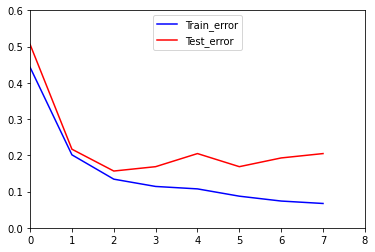

In [21]:
import matplotlib.pyplot as plt
train_errors = []
test_errors = []
max_depth = [0,1,2,3,4,5,6,7]
for i in range(8):
    tr_e,te_e = get_data("politicians_train.tsv","politicians_test.tsv",i,"train.labels","test.labels","metrics.txt")
    train_errors.append(tr_e)
    test_errors.append(te_e)

plt.plot(max_depth, train_errors,'b',label="Train_error")
plt.plot(max_depth, test_errors,'r',label="Test_error")
plt.ylim(0, 0.6)
plt.xlim(0,8)
plt.legend(loc="upper center")
plt.savefig('4_2.png')
plt.show()

In [18]:
# if __name__ == '__main__':
#     import sys
#     import math
#     main(sys.argv[1],sys.argv[2],sys.argv[3],sys.argv[4],sys.argv[5],sys.argv[6])